In [34]:
# Cell 1: Imports and experiment configuration

import numpy as np
import pandas as pd
import yfinance as yf

from sklearn.preprocessing import StandardScaler
from sklearn.covariance import graphical_lasso, ledoit_wolf  # <- add ledoit_wolf

%matplotlib widget
import matplotlib.pyplot as plt

# If you want to also have your external script available:
# import calculate_glasso

# Experiment configuration
TICKERS = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'TSLA', 'SPY', 'QQQ', 'GLD']  # or your full universe
START_DATE = "2021-01-01"
END_DATE = "2024-01-01"

ALPHA = 0.4                      # Graphical Lasso regularization parameter
WINDOW_WEEKS = 24
TRADING_DAYS_PER_WEEK = 5
WINDOW_SIZE = WINDOW_WEEKS * TRADING_DAYS_PER_WEEK  # approx 10 trading days

print("Config loaded.")
print("  n_tickers:", len(TICKERS))
print("  date range:", START_DATE, "->", END_DATE)
print("  WINDOW_SIZE (trading days):", WINDOW_SIZE)

Config loaded.
  n_tickers: 8
  date range: 2021-01-01 -> 2024-01-01
  WINDOW_SIZE (trading days): 120


In [35]:
# Cell 2: Data retrieval and returns computation

def get_data(tickers, start_date, end_date):
    """
    Download adjusted close prices from Yahoo Finance and compute daily returns.
    """
    print("Downloading data from Yahoo Finance...")
    data = yf.download(tickers, start=start_date, end=end_date)['Close']
    
    # Make sure we always have a DataFrame
    if isinstance(data, pd.Series):
        data = data.to_frame()
    
    # Calculate returns and drop days with any missing values across tickers
    returns = data.pct_change().dropna(how="any")
    print(f"✅ Retrieved {returns.shape[1]} assets over {returns.shape[0]} days")
    return returns

# Retrieve 1-year daily returns
returns_df = get_data(TICKERS, START_DATE, END_DATE)

print("\nreturns_df info:")
print("  shape:", returns_df.shape)
print("  columns (tickers):", list(returns_df.columns))
print(returns_df.head())


/var/folders/vh/qb76ftk17737fk165cbplvw00000gn/T/ipykernel_52719/745956638.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)['Close']
[**********************62%*****                  ]  5 of 8 completed

[*********************100%***********************]  8 of 8 completed

✅ Retrieved 8 assets over 752 days

returns_df info:
  shape: (752, 8)
  columns (tickers): ['AAPL', 'AMZN', 'GLD', 'GOOG', 'MSFT', 'QQQ', 'SPY', 'TSLA']
Ticker          AAPL      AMZN       GLD      GOOG      MSFT       QQQ  \
Date                                                                     
2021-01-05  0.012364  0.010004  0.002962  0.007337  0.000964  0.008244   
2021-01-06 -0.033662 -0.024897 -0.016241 -0.003234 -0.025929 -0.013853   
2021-01-07  0.034123  0.007577 -0.002335  0.029943  0.028457  0.024192   
2021-01-08  0.008631  0.006496 -0.034210  0.011168  0.006093  0.012858   
2021-01-11 -0.023249 -0.021519 -0.001961 -0.022405 -0.009699 -0.014450   

Ticker           SPY      TSLA  
Date                            
2021-01-05  0.006887  0.007317  
2021-01-06  0.005979  0.028390  
2021-01-07  0.014858  0.079447  
2021-01-08  0.005698  0.078403  
2021-01-11 -0.006741 -0.078214  


In [36]:
# Cell 3: Split the returns into fixed 2-week windows

def split_into_windows(returns_df, window_size):
    """
    Split the returns DataFrame into non-overlapping windows
    of length `window_size` along the time axis.
    """
    n_samples = returns_df.shape[0]
    n_windows = n_samples // window_size  # floor division

    windows = []
    for i in range(n_windows):
        start = i * window_size
        end = start + window_size
        win = returns_df.iloc[start:end]
        windows.append(win)
    return windows

windows = split_into_windows(returns_df, WINDOW_SIZE)

print("Number of windows:", len(windows))
if len(windows) > 0:
    print("First window shape:", windows[0].shape)
    print("First window date range:", windows[0].index[0].date(), "->", windows[0].index[-1].date())
    print("Last window date range:", windows[-1].index[0].date(), "->", windows[-1].index[-1].date())


Number of windows: 6
First window shape: (120, 8)
First window date range: 2021-01-05 -> 2021-06-25
Last window date range: 2023-05-24 -> 2023-11-13


/Users/mavio/Library/Python/3.12/lib/python/site-packages/sklearn/covariance/_graph_lasso.py:199: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: -2.935e-03
  warnings.warn(
/var/folders/vh/qb76ftk17737fk165cbplvw00000gn/T/ipykernel_52719/631029632.py:118: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/ipympl/backend_nbagg.py:342: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  self.figure.savefig(buf, format='png', dpi='figure')


Sample Var. conditioning: 146.3827910233809
 Glasso Var. conditioning: 5.35622881953945
Sample Var. conditioning: 77.48653926530638
 Glasso Var. conditioning: 4.0368144964679145
Sample Var. conditioning: 285.2243319509024
 Glasso Var. conditioning: 7.119782531404163
Sample Var. conditioning: 435.30439246488197
 Glasso Var. conditioning: 6.922508775315309
Sample Var. conditioning: 248.41726971457973
 Glasso Var. conditioning: 5.565998131461847
Sample Var. conditioning: 105.39580089348061
 Glasso Var. conditioning: 4.276279772641478
Covariance and precision matrices computed.
  number of windows: 6
  covariance matrix shape: (8, 8)


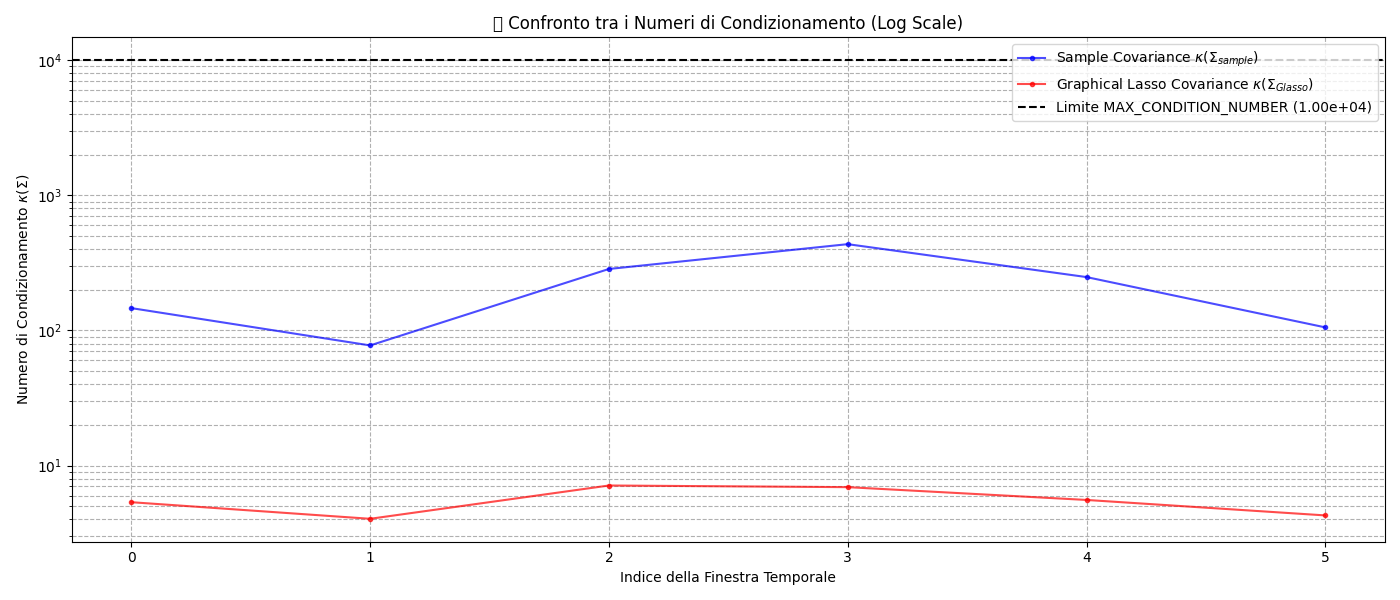


--- Analisi Dettagliata del Condizionamento ---
Limite MAX_CONDITION_NUMBER utilizzato: 1.00e+04
Numero totale di finestre: 6
----------------------------------------
Finestre mal condizionate (Campione): 0 (0.00%)
Finestre mal condizionate (Glasso): 0 (0.00%)


In [37]:
# Cell 4: Covariance and precision estimation per window (sample and Glasso)
# Adds a condition-number check before attempting to invert the sample covariance.

MAX_CONDITION_NUMBER = 1e4  # threshold to consider a matrix "well-conditioned"


def compute_cov_prec_for_window(window_returns, alpha):
    """
    Given a returns window (T x N), standardize it, then:
    - compute the sample covariance of standardized data
    - compute the inverse (precision) of the sample covariance, but only if it is
      sufficiently well-conditioned (based on the condition number)
    - compute a Ledoit–Wolf covariance for input to Graphical Lasso
    - apply Graphical Lasso to obtain a regularized covariance + precision

    Returns
    -------
    sample_cov : (N, N) ndarray
        Sample covariance matrix of standardized returns.
    sample_prec : (N, N) ndarray or None
        Inverse (precision) of sample_cov. Uses pseudo-inverse if poorly conditioned,
        or None if even pseudo-inverse fails.
    glasso_cov : (N, N) ndarray
        Covariance matrix estimated by Graphical Lasso.
    glasso_prec : (N, N) ndarray
        Precision matrix estimated by Graphical Lasso.
    """
    # --- STANDARDIZE RETURNS IN THE WINDOW ---
    scaler = StandardScaler()
    X = scaler.fit_transform(window_returns.values)  # shape: (T, N)

    # --- UNREGULARIZED SAMPLE COVARIANCE ---
    sample_cov = np.cov(X, rowvar=False)  # shape: (N, N)

    # --- CONDITION NUMBER CHECK ---
    try:
        cond_sample = np.linalg.cond(sample_cov) # 2-norm, computed directly using the SVD
    except np.linalg.LinAlgError as e:
        print(
            "Warning: could not compute condition number for sample covariance "
            f"in this window. Treating it as ill-conditioned.\n  Details: {e}"
        )
        cond_sample = np.inf

    sample_prec = None
    # is_well_conditioned = np.isfinite(cond_sample) and cond_sample < MAX_CONDITION_NUMBER

    try:
        sample_prec = np.linalg.inv(sample_cov)
    except np.linalg.LinAlgError as e:
        print(
            "Warning:"
            f"(cond={cond_sample:.2e}) and inversion failed;\n"
            f"  Details: {e}"
        )
        sample_prec = None


    # --- LEDOIT–WOLF COVARIANCE FOR GLASSO INPUT ---
    # We use standardized data and assume it is centered.
    emp_cov, _ = ledoit_wolf(X, assume_centered=True)

    # --- GRAPHICAL LASSO ---
    glasso_cov, glasso_prec = graphical_lasso(emp_cov, alpha=alpha, tol=1e-4)
    
    cond_glasso = np.linalg.cond(glasso_cov)
    
    print(f"Sample Var. conditioning: {cond_sample}\n Glasso Var. conditioning: {cond_glasso}")

    return sample_cov, cond_sample, sample_prec, glasso_cov, cond_glasso, glasso_prec


# Run estimation on all windows
sample_covs = []
sample_precs = []   # list of sample precision matrices (or None)
cond_sample = []
glasso_covs = []
glasso_precs = []   # list of Glasso precision matrices
cond_glasso = []

for idx, win in enumerate(windows):
    s_cov, s_cond, s_prec, g_cov, g_cond, g_prec = compute_cov_prec_for_window(win, ALPHA)
    sample_covs.append(s_cov)
    cond_sample.append(s_cond)
    sample_precs.append(s_prec)
    glasso_covs.append(g_cov)
    cond_glasso.append(g_cond)
    glasso_precs.append(g_prec)

print("Covariance and precision matrices computed.")
print("  number of windows:", len(sample_covs))
if len(sample_covs) > 0:
    print("  covariance matrix shape:", sample_covs[0].shape)
    

# --- 2. Funzione di Plotting e Analisi ---

window_indices = np.arange(len(cond_sample))

plt.figure(figsize=(14, 6))

# Plot dei valori di condizionamento campionari
plt.plot(window_indices, cond_sample, label='Sample Covariance $\\kappa(\\Sigma_{sample})$', marker='.', linestyle='-', color='blue', alpha=0.7)

# Plot dei valori di condizionamento Glasso
plt.plot(window_indices, cond_glasso, label='Graphical Lasso Covariance $\\kappa(\\Sigma_{Glasso})$', marker='.', linestyle='-', color='red', alpha=0.7)

# Linea orizzontale per il limite di mal condizionamento
plt.axhline(MAX_CONDITION_NUMBER, color='k', linestyle='--', label=f'Limite MAX_CONDITION_NUMBER ({MAX_CONDITION_NUMBER:.2e})')

# Impostazioni del grafico
plt.yscale('log') # Usa una scala logaritmica per vedere i grandi valori
plt.title('📈 Confronto tra i Numeri di Condizionamento (Log Scale)')
plt.xlabel('Indice della Finestra Temporale')
plt.ylabel('Numero di Condizionamento $\\kappa(\\Sigma)$')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()

# --- 3. Analisi del Condizionamento ---

# Controlla per i valori mal condizionati (condizionamento > Limite)
num_windows = len(window_indices)
num_sample_ill = np.sum(np.array(cond_sample) > MAX_CONDITION_NUMBER)
num_glasso_ill = np.sum(np.array(cond_glasso) > MAX_CONDITION_NUMBER)

print("\n--- Analisi Dettagliata del Condizionamento ---")
print(f"Limite MAX_CONDITION_NUMBER utilizzato: {MAX_CONDITION_NUMBER:.2e}")
print(f"Numero totale di finestre: {num_windows}")
print("-" * 40)
print(f"Finestre mal condizionate (Campione): {num_sample_ill} ({num_sample_ill / num_windows * 100:.2f}%)")
print(f"Finestre mal condizionate (Glasso): {num_glasso_ill} ({num_glasso_ill / num_windows * 100:.2f}%)")


In [38]:
# Cell 5: Frobenius norm differences across consecutive windows

def frobenius_differences(cov_list):
    """
    Compute Frobenius norm of differences between consecutive
    covariance matrices in `cov_list`.
    """
    diffs = []
    for i in range(len(cov_list) - 1):
        delta = (cov_list[i+1] - cov_list[i])
        frob = np.linalg.norm(delta, ord='fro')/np.linalg.norm(cov_list[i], ord='fro')    # NORMALIZATION
        diffs.append(frob)
    return np.array(diffs)

fro_sample = frobenius_differences(sample_covs)
fro_glasso = frobenius_differences(glasso_covs)

# Build a DataFrame for easier inspection
window_pairs = []
for i in range(len(windows) - 1):
    w1 = windows[i]
    w2 = windows[i+1]
    label = f"{w1.index[0].date()}–{w1.index[-1].date()} -> {w2.index[0].date()}–{w2.index[-1].date()}"
    window_pairs.append(label)

results_df = pd.DataFrame({
    "window_pair": window_pairs,
    "frobenius_sample": fro_sample,
    "frobenius_glasso": fro_glasso,
})

print("Frobenius differences between consecutive windows:")
print(results_df.head())
print("\nSummary statistics:")
print("  mean(sample) :", results_df["frobenius_sample"].mean())
print("  mean(glasso) :", results_df["frobenius_glasso"].mean())
print("  std(sample)  :", results_df["frobenius_sample"].std())
print("  std(glasso)  :", results_df["frobenius_glasso"].std())


Frobenius differences between consecutive windows:
                                      window_pair  frobenius_sample  \
0  2021-01-05–2021-06-25 -> 2021-06-28–2021-12-15          0.293807   
1  2021-06-28–2021-12-15 -> 2021-12-16–2022-06-08          0.427378   
2  2021-12-16–2022-06-08 -> 2022-06-09–2022-11-29          0.351046   
3  2022-06-09–2022-11-29 -> 2022-11-30–2023-05-23          0.272728   
4  2022-11-30–2023-05-23 -> 2023-05-24–2023-11-13          0.165298   

   frobenius_glasso  
0          0.226718  
1          0.422938  
2          0.089134  
3          0.211752  
4          0.193483  

Summary statistics:
  mean(sample) : 0.3020515577839934
  mean(glasso) : 0.2288050084124031
  std(sample)  : 0.09712962827665471
  std(glasso)  : 0.12117990440754436


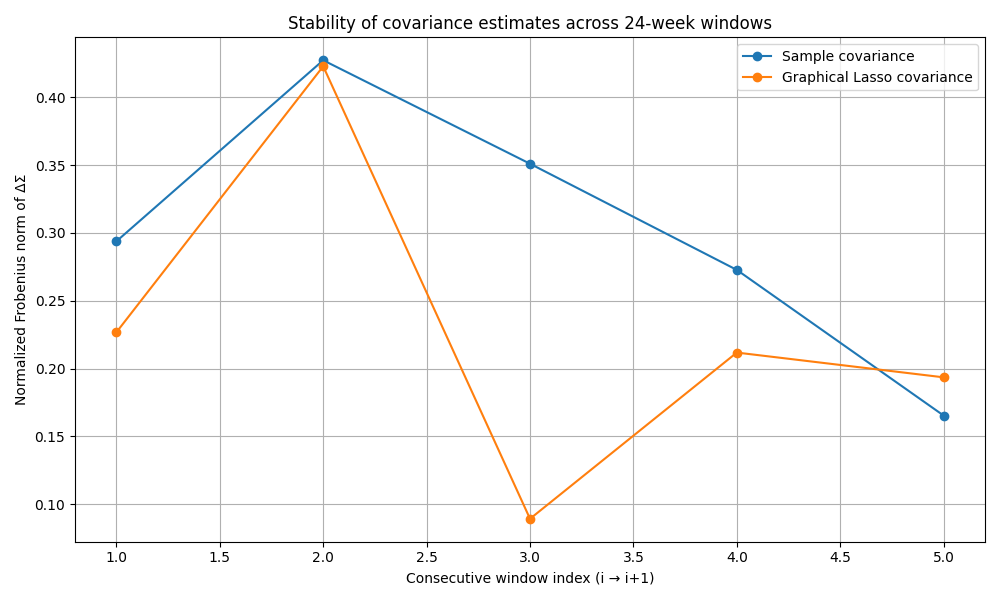

Stability comparison plot generated.


In [39]:
# Cell 6: Plot sample vs Glasso Frobenius norms

plt.figure(figsize=(10, 6))
x = np.arange(1, len(fro_sample) + 1)

plt.plot(x, fro_sample, marker='o', label="Sample covariance")
plt.plot(x, fro_glasso, marker='o', label="Graphical Lasso covariance")

plt.xlabel("Consecutive window index (i → i+1)")
plt.ylabel("Normalized Frobenius norm of ΔΣ")
plt.title(f"Stability of covariance estimates across {WINDOW_WEEKS}-week windows")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("Stability comparison plot generated.")


Frobenius differences between consecutive windows (PRECISION matrices):
  window_pair  frobenius_sample_prec  frobenius_glasso_prec
0         0→1               0.418383               0.179132
1         1→2               1.825567               0.316444
2         2→3               0.511496               0.110840
3         3→4               0.366904               0.172772
4         4→5               0.530339               0.150077

Summary statistics for precision matrices:
  mean(sample precision) : 0.7305377669493014
  mean(glasso precision) : 0.18585293877791748
  std(sample precision)  : 0.6157959813860777
  std(glasso precision)  : 0.07774477597832334


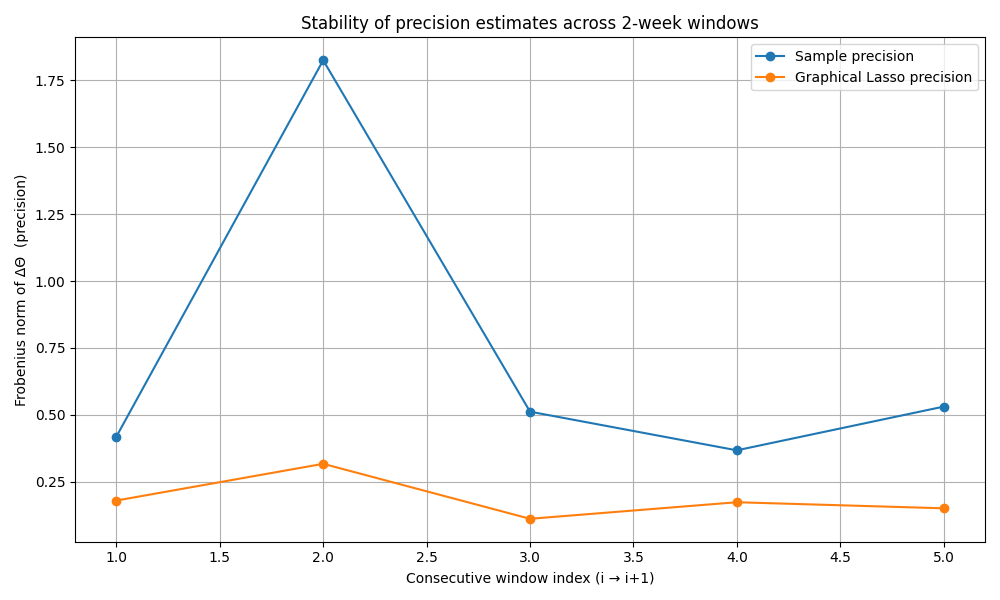

Precision stability comparison plot generated.
[0.41838299 1.82556731 0.51149566 0.3669043  0.53033858]
[0.17913249 0.3164435  0.11084039 0.17277159 0.15007672]


In [40]:
# Cell 7: Frobenius norm differences for precision matrices (sample vs Glasso)

# Reuse the same helper; it works for any list of matrices (covariances or precisions)
fro_sample_prec = frobenius_differences(sample_precs)
fro_glasso_prec = frobenius_differences(glasso_precs)

# Label window pairs i -> i+1
window_pairs_prec = [f"{i}→{i+1}" for i in range(len(fro_sample_prec))]

prec_results_df = pd.DataFrame({
    "window_pair": window_pairs_prec,
    "frobenius_sample_prec": fro_sample_prec,
    "frobenius_glasso_prec": fro_glasso_prec,
})

print("Frobenius differences between consecutive windows (PRECISION matrices):")
print(prec_results_df.head())

print("\nSummary statistics for precision matrices:")
print("  mean(sample precision) :", prec_results_df["frobenius_sample_prec"].mean())
print("  mean(glasso precision) :", prec_results_df["frobenius_glasso_prec"].mean())
print("  std(sample precision)  :", prec_results_df["frobenius_sample_prec"].std())
print("  std(glasso precision)  :", prec_results_df["frobenius_glasso_prec"].std())

# Plot the stability over window pairs
plt.figure(figsize=(10, 6))
x = np.arange(1, len(fro_sample_prec) + 1)

plt.plot(x, fro_sample_prec, marker='o', label="Sample precision")
plt.plot(x, fro_glasso_prec, marker='o', label="Graphical Lasso precision")

plt.xlabel("Consecutive window index (i → i+1)")
plt.ylabel("Frobenius norm of ΔΘ  (precision)")
plt.title("Stability of precision estimates across 2-week windows")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("Precision stability comparison plot generated.")


print(fro_sample_prec)
print(fro_glasso_prec)


**Interpretation**: Why Condition Number Drives Stability

In our code, we calculated $\kappa_2(\Sigma)$ using np.linalg.cond, which computes the ratio of the largest to the smallest singular value via SVD ($\sigma_{max} / \sigma_{min}$).

When we move from window $t$ to $t+1$, the input covariance matrix $\Sigma$ changes slightly (perturbation). The condition number tells us how much that small change is amplified when we compute the inverse (Precision Matrix $\Omega = \Sigma^{-1}$).The theoretical bound on relative error is:$$\frac{\|\Delta \Sigma^{-1}\|}{\|\Sigma^{-1}\|} \leq \kappa(\Sigma) \cdot \frac{\|\Delta \Sigma\|}{\|\Sigma\|}$$

**Numerical Example from Our Results**:
1. When $\kappa_2(\Sigma)$ ~20,000: a tiny $5\%$ change in the input data (rolling the window forward) can be amplified up to $20,000 \times 0.05 = 1,000$ times (100,000%) in the inverse matrix. This explains why our consecutive Frobenius differences for the sample precision are massive (mean ~1,272). The solution is numerically unstable and jumps wildly.
2. The Graphical Lasso (Well-Conditioned): The regularization forced $\kappa$ down to ~2 to 5.The Mechanism: With a $\kappa \approx 3$, a $5\%$ change in input results in only a $3 \times 0.05 = 0.15$ (15%) change in the inverse. 

Observed Result: Our observed Frobenius differences are very small. The estimate is robust and evolves smoothly over time.

Computing GMV (Markowitz min-var) portfolios and evaluating on next window...
Window 0->1: cumret Sample=0.3154, Glasso=0.1828 | lev Sample=3.84, Glasso=1.07
Window 4->5: cumret Sample=0.0992, Glasso=0.1223 | lev Sample=4.53, Glasso=1.04

Summary Statistics (per-window OOS on t+1)

Sample (pseudo-inverse if needed):
  Mean cumulative return: 0.060481
  Std cumulative return:  0.200594
  Mean Sharpe (daily):     0.0417
  Mean volatility (daily): 0.018248
  Mean leverage (sum|w|):  3.83
  Mean turnover (sum|Δw|): 1.53

Glasso:
  Mean cumulative return: 0.041121
  Std cumulative return:  0.170517
  Mean Sharpe (daily):     0.0483
  Mean volatility (daily): 0.014676
  Mean leverage (sum|w|):  1.03
  Mean turnover (sum|Δw|): 0.21


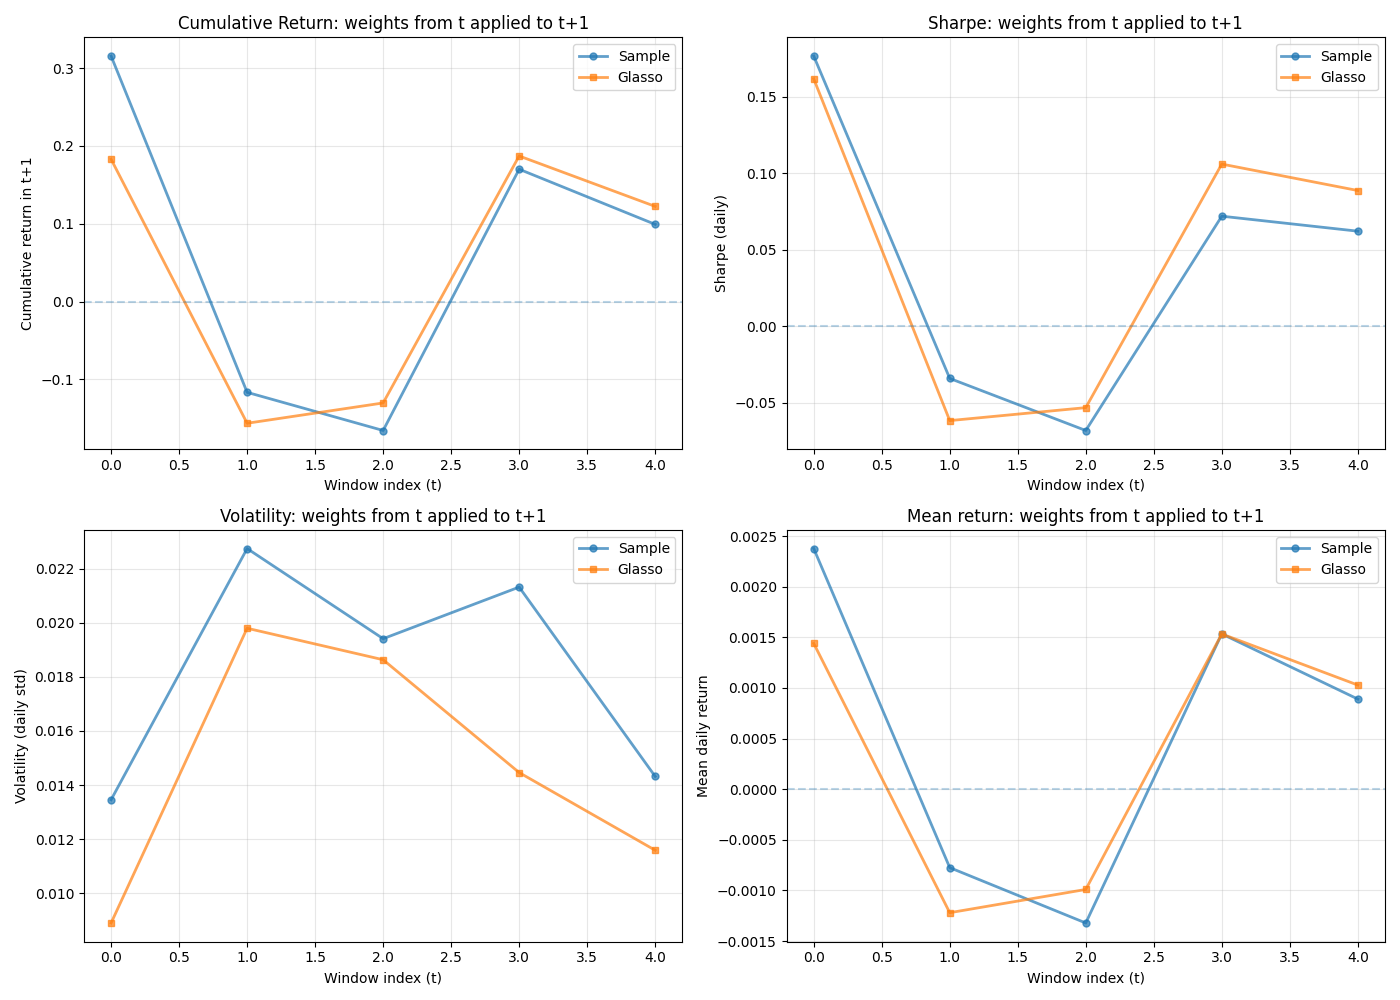

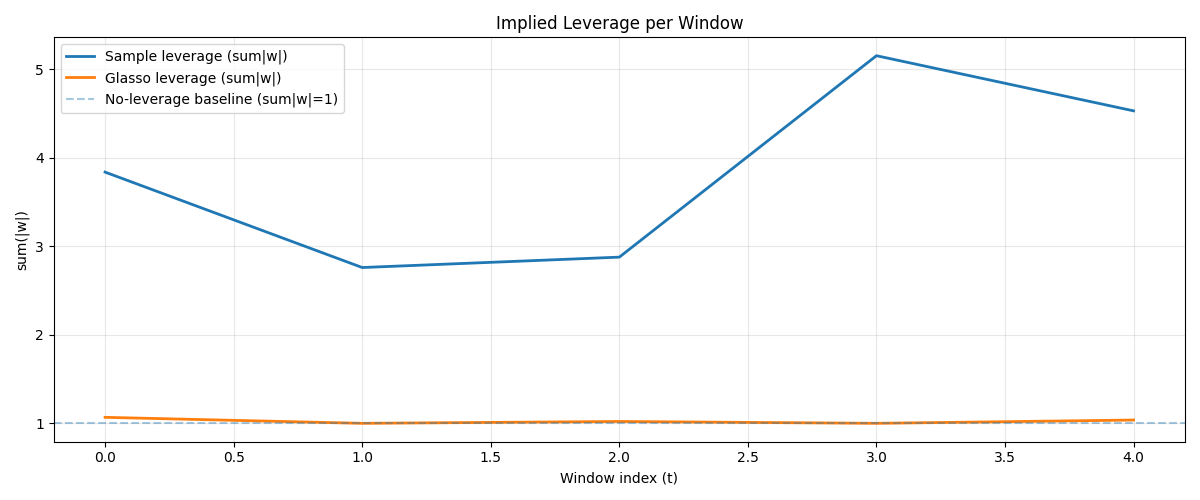

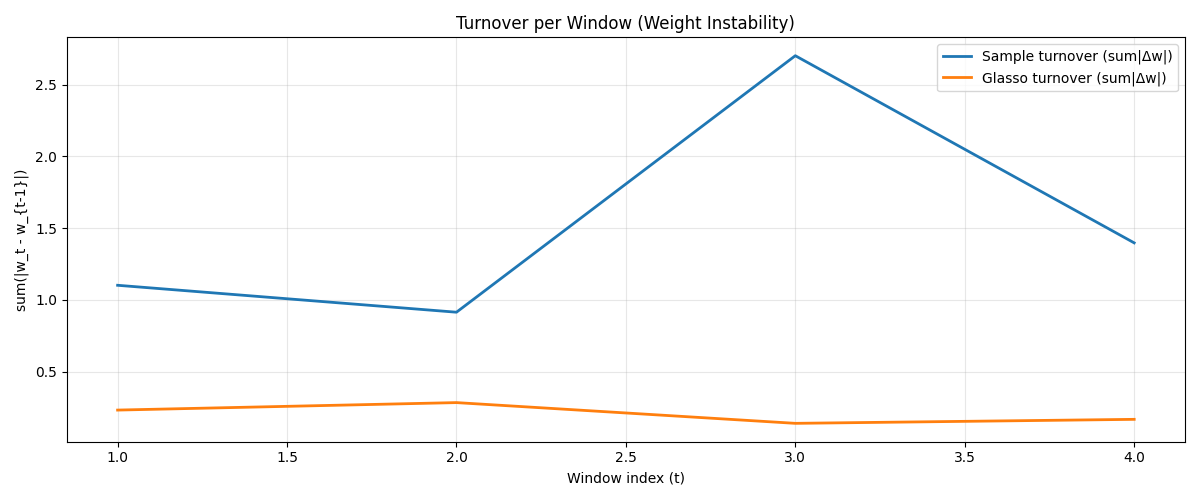

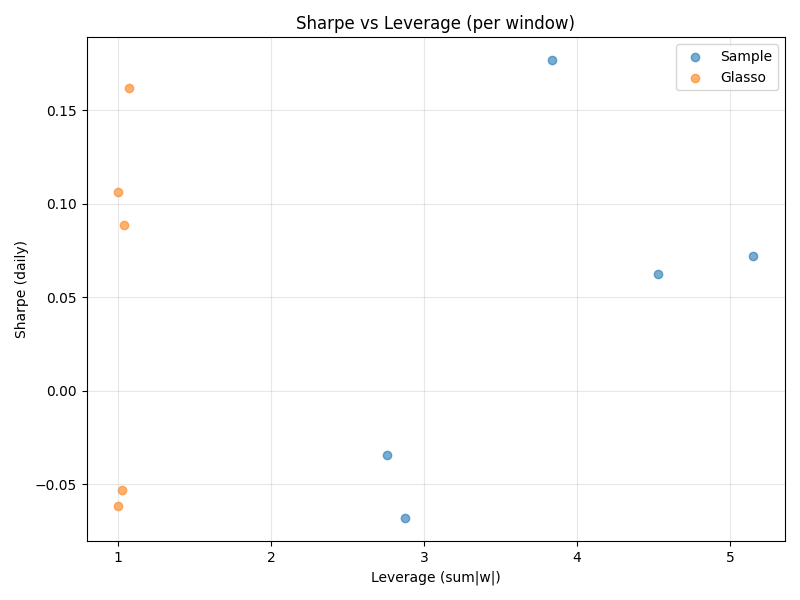

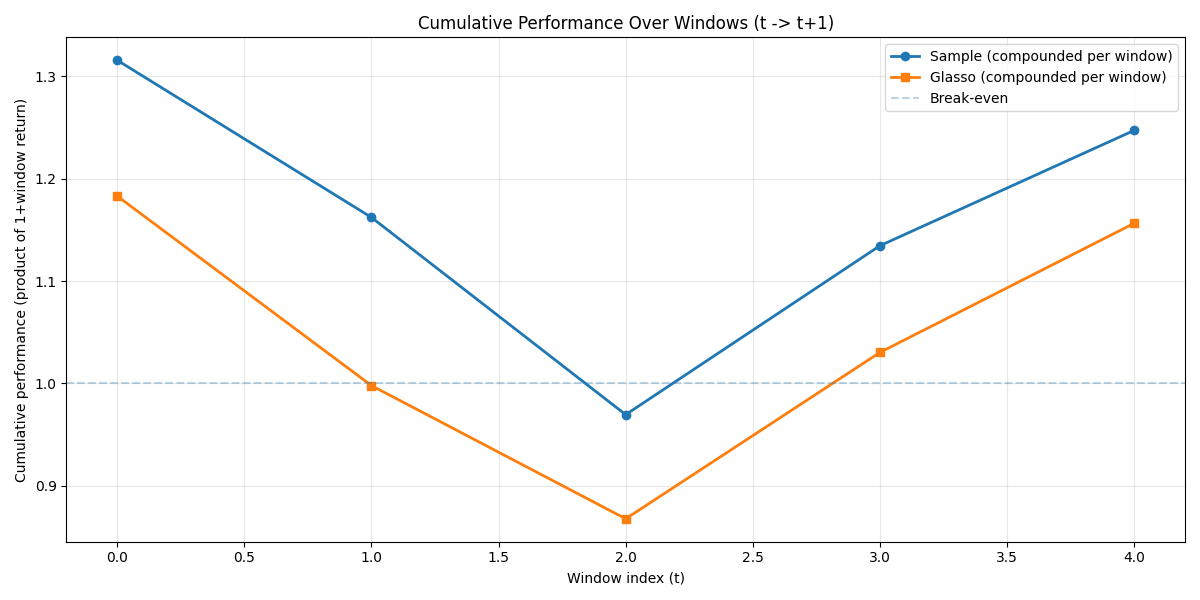


✅ GMV portfolio performance + leverage/turnover diagnostics complete!


In [41]:
# Cell 8: Markowitz (GMV) Portfolio Performance: Window t -> Window t+1
# Compare GMV using Sample (pseudo-inverse if needed) vs Glasso precision
# + Diagnostics to show "unnecessary risk": leverage (sum|w|) and turnover (sum|Δw|)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def min_variance_portfolio(Theta):
    """
    Global Minimum Variance portfolio under 1'w = 1, short-selling allowed.
    Uses only the precision matrix Theta = Sigma^{-1}.
    
    w* = Theta 1 / (1' Theta 1)
    """
    ones = np.ones(Theta.shape[0])
    A = ones @ Theta @ ones
    if A <= 0 or not np.isfinite(A):
        raise ValueError("Invalid A = 1' Theta 1. Precision matrix may be invalid.")
    w_mv = (Theta @ ones) / A
    return w_mv

def portfolio_returns(w, returns_df):
    """
    Compute portfolio daily returns for each day in returns_df (T x N).
    r_p = R @ w
    """
    if isinstance(returns_df, pd.DataFrame):
        if isinstance(w, pd.Series):
            w_aligned = w.reindex(returns_df.columns, fill_value=0.0).values
        else:
            w_aligned = np.asarray(w)
        return (returns_df.values @ w_aligned).flatten()
    else:
        return (np.asarray(returns_df) @ np.asarray(w)).flatten()

def get_sample_precision(t):
    """
    Return a usable precision matrix for the sample estimator at window t.
    If precomputed inverse is missing (None), fall back to pseudo-inverse of sample covariance.
    """
    prec = sample_precs[t]
    if prec is None:
        cov = sample_covs[t]
        prec = np.linalg.pinv(cov)
    return prec

# -----------------------------
# Storage for results
# -----------------------------
results = {
    "window_idx": [],

    # Out-of-sample performance on window t+1
    "sample_cumulative_return": [],
    "glasso_cumulative_return": [],
    "sample_sharpe": [],
    "glasso_sharpe": [],
    "sample_volatility": [],
    "glasso_volatility": [],
    "sample_mean_return": [],
    "glasso_mean_return": [],

    # Diagnostics (risk / instability)
    "sample_leverage_L1": [],     # sum |w|
    "glasso_leverage_L1": [],
    "sample_turnover_L1": [],     # sum |w_t - w_{t-1}|
    "glasso_turnover_L1": [],
}

print("Computing GMV (Markowitz min-var) portfolios and evaluating on next window...")
print("=" * 70)

# We'll keep previous weights to compute turnover
prev_w_sample = None
prev_w_glasso = None

# Iterate over windows (skip last window as there's no t+1)
for t in range(len(windows) - 1):
    window_t = windows[t]
    window_t1 = windows[t + 1]

    # Ensure same asset universe in t and t+1
    if not window_t.columns.equals(window_t1.columns):
        print(f"Warning: Window {t} and {t+1} have different assets. Skipping (would need recompute covariances).")
        continue

    # Get precision matrices for window t
    try:
        sample_prec_t = get_sample_precision(t)
        glasso_prec_t = glasso_precs[t]
    except Exception as e:
        print(f"Window {t}: could not retrieve precision matrices: {e}. Skipping.")
        continue

    # Compute GMV weights
    try:
        w_sample = min_variance_portfolio(sample_prec_t)
        w_glasso = min_variance_portfolio(glasso_prec_t)
    except Exception as e:
        print(f"Window {t}: error computing GMV weights: {e}. Skipping.")
        continue

    # Diagnostics: leverage (sum|w|)
    lev_sample = float(np.sum(np.abs(w_sample)))
    lev_glasso = float(np.sum(np.abs(w_glasso)))

    # Diagnostics: turnover (sum|Δw|)
    if prev_w_sample is None:
        to_sample = np.nan
        to_glasso = np.nan
    else:
        to_sample = float(np.sum(np.abs(w_sample - prev_w_sample)))
        to_glasso = float(np.sum(np.abs(w_glasso - prev_w_glasso)))

    # Apply weights to window t+1 returns (out-of-sample)
    w_sample_series = pd.Series(w_sample, index=window_t.columns)
    w_glasso_series = pd.Series(w_glasso, index=window_t.columns)

    portfolio_ret_sample = portfolio_returns(w_sample_series, window_t1)
    portfolio_ret_glasso = portfolio_returns(w_glasso_series, window_t1)

    # Performance metrics (daily)
    cumret_sample = float(np.prod(1.0 + portfolio_ret_sample) - 1.0)
    cumret_glasso = float(np.prod(1.0 + portfolio_ret_glasso) - 1.0)

    meanret_sample = float(np.mean(portfolio_ret_sample))
    meanret_glasso = float(np.mean(portfolio_ret_glasso))

    # Use ddof=1 for sample std (more standard); keep ddof=0 if you prefer
    vol_sample = float(np.std(portfolio_ret_sample, ddof=1))
    vol_glasso = float(np.std(portfolio_ret_glasso, ddof=1))

    # Sharpe (daily), rf=0
    sharpe_sample = (meanret_sample / vol_sample) if vol_sample > 1e-12 else 0.0
    sharpe_glasso = (meanret_glasso / vol_glasso) if vol_glasso > 1e-12 else 0.0

    # Store results
    results["window_idx"].append(t)

    results["sample_cumulative_return"].append(cumret_sample)
    results["glasso_cumulative_return"].append(cumret_glasso)

    results["sample_sharpe"].append(sharpe_sample)
    results["glasso_sharpe"].append(sharpe_glasso)

    results["sample_volatility"].append(vol_sample)
    results["glasso_volatility"].append(vol_glasso)

    results["sample_mean_return"].append(meanret_sample)
    results["glasso_mean_return"].append(meanret_glasso)

    results["sample_leverage_L1"].append(lev_sample)
    results["glasso_leverage_L1"].append(lev_glasso)

    results["sample_turnover_L1"].append(to_sample)
    results["glasso_turnover_L1"].append(to_glasso)

    # Update previous weights
    prev_w_sample = w_sample
    prev_w_glasso = w_glasso

    if (t + 1) % 5 == 0 or t == 0:
        print(f"Window {t}->{t+1}: cumret Sample={cumret_sample:.4f}, Glasso={cumret_glasso:.4f} | "
              f"lev Sample={lev_sample:.2f}, Glasso={lev_glasso:.2f}")

# Convert to DataFrame
results_df = pd.DataFrame(results)

if len(results_df) == 0:
    print("\n⚠️  No results computed. Check for warnings above.")
else:
    print("\n" + "=" * 70)
    print("Summary Statistics (per-window OOS on t+1)")
    print("=" * 70)

    print("\nSample (pseudo-inverse if needed):")
    print(f"  Mean cumulative return: {results_df['sample_cumulative_return'].mean():.6f}")
    print(f"  Std cumulative return:  {results_df['sample_cumulative_return'].std():.6f}")
    print(f"  Mean Sharpe (daily):     {results_df['sample_sharpe'].mean():.4f}")
    print(f"  Mean volatility (daily): {results_df['sample_volatility'].mean():.6f}")
    print(f"  Mean leverage (sum|w|):  {results_df['sample_leverage_L1'].mean():.2f}")
    print(f"  Mean turnover (sum|Δw|): {results_df['sample_turnover_L1'].dropna().mean():.2f}")

    print("\nGlasso:")
    print(f"  Mean cumulative return: {results_df['glasso_cumulative_return'].mean():.6f}")
    print(f"  Std cumulative return:  {results_df['glasso_cumulative_return'].std():.6f}")
    print(f"  Mean Sharpe (daily):     {results_df['glasso_sharpe'].mean():.4f}")
    print(f"  Mean volatility (daily): {results_df['glasso_volatility'].mean():.6f}")
    print(f"  Mean leverage (sum|w|):  {results_df['glasso_leverage_L1'].mean():.2f}")
    print(f"  Mean turnover (sum|Δw|): {results_df['glasso_turnover_L1'].dropna().mean():.2f}")

    x = results_df["window_idx"]

    # -----------------------------
    # Plot A: Performance (same as before)
    # -----------------------------
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    ax1 = axes[0, 0]
    ax1.plot(x, results_df["sample_cumulative_return"], marker="o", label="Sample", linewidth=2, markersize=5, alpha=0.7)
    ax1.plot(x, results_df["glasso_cumulative_return"], marker="s", label="Glasso", linewidth=2, markersize=5, alpha=0.7)
    ax1.axhline(0, linestyle="--", alpha=0.3)
    ax1.set_xlabel("Window index (t)")
    ax1.set_ylabel("Cumulative return in t+1")
    ax1.set_title("Cumulative Return: weights from t applied to t+1")
    ax1.legend()
    ax1.grid(alpha=0.3)

    ax2 = axes[0, 1]
    ax2.plot(x, results_df["sample_sharpe"], marker="o", label="Sample", linewidth=2, markersize=5, alpha=0.7)
    ax2.plot(x, results_df["glasso_sharpe"], marker="s", label="Glasso", linewidth=2, markersize=5, alpha=0.7)
    ax2.axhline(0, linestyle="--", alpha=0.3)
    ax2.set_xlabel("Window index (t)")
    ax2.set_ylabel("Sharpe (daily)")
    ax2.set_title("Sharpe: weights from t applied to t+1")
    ax2.legend()
    ax2.grid(alpha=0.3)

    ax3 = axes[1, 0]
    ax3.plot(x, results_df["sample_volatility"], marker="o", label="Sample", linewidth=2, markersize=5, alpha=0.7)
    ax3.plot(x, results_df["glasso_volatility"], marker="s", label="Glasso", linewidth=2, markersize=5, alpha=0.7)
    ax3.set_xlabel("Window index (t)")
    ax3.set_ylabel("Volatility (daily std)")
    ax3.set_title("Volatility: weights from t applied to t+1")
    ax3.legend()
    ax3.grid(alpha=0.3)

    ax4 = axes[1, 1]
    ax4.plot(x, results_df["sample_mean_return"], marker="o", label="Sample", linewidth=2, markersize=5, alpha=0.7)
    ax4.plot(x, results_df["glasso_mean_return"], marker="s", label="Glasso", linewidth=2, markersize=5, alpha=0.7)
    ax4.axhline(0, linestyle="--", alpha=0.3)
    ax4.set_xlabel("Window index (t)")
    ax4.set_ylabel("Mean daily return")
    ax4.set_title("Mean return: weights from t applied to t+1")
    ax4.legend()
    ax4.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    # -----------------------------
    # Plot B: Diagnostics to show "unnecessary risk"
    # -----------------------------
    plt.figure(figsize=(12, 5))
    plt.plot(x, results_df["sample_leverage_L1"], label="Sample leverage (sum|w|)", linewidth=2)
    plt.plot(x, results_df["glasso_leverage_L1"], label="Glasso leverage (sum|w|)", linewidth=2)
    plt.axhline(1.0, linestyle="--", alpha=0.4, label="No-leverage baseline (sum|w|=1)")
    plt.title("Implied Leverage per Window")
    plt.xlabel("Window index (t)")
    plt.ylabel("sum(|w|)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.plot(x, results_df["sample_turnover_L1"], label="Sample turnover (sum|Δw|)", linewidth=2)
    plt.plot(x, results_df["glasso_turnover_L1"], label="Glasso turnover (sum|Δw|)", linewidth=2)
    plt.title("Turnover per Window (Weight Instability)")
    plt.xlabel("Window index (t)")
    plt.ylabel("sum(|w_t - w_{t-1}|)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Scatter: Sharpe vs Leverage (per-window)
    df_sc = results_df.dropna(subset=["sample_leverage_L1", "glasso_leverage_L1", "sample_sharpe", "glasso_sharpe"]).copy()

    plt.figure(figsize=(8, 6))
    plt.scatter(df_sc["sample_leverage_L1"], df_sc["sample_sharpe"], alpha=0.6, label="Sample")
    plt.scatter(df_sc["glasso_leverage_L1"], df_sc["glasso_sharpe"], alpha=0.6, label="Glasso")
    plt.xlabel("Leverage (sum|w|)")
    plt.ylabel("Sharpe (daily)")
    plt.title("Sharpe vs Leverage (per window)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # -----------------------------
    # Plot C: Cumulative over windows (as in your original cell)
    # NOTE: This compounds per-window cumulative returns. If your windows overlap,
    # this is not a true daily equity curve.
    # -----------------------------
    cumulative_sample = np.cumprod(1.0 + results_df["sample_cumulative_return"].values)
    cumulative_glasso = np.cumprod(1.0 + results_df["glasso_cumulative_return"].values)

    plt.figure(figsize=(12, 6))
    plt.plot(x, cumulative_sample, marker="o", label="Sample (compounded per window)", linewidth=2)
    plt.plot(x, cumulative_glasso, marker="s", label="Glasso (compounded per window)", linewidth=2)
    plt.axhline(1.0, linestyle="--", alpha=0.3, label="Break-even")
    plt.xlabel("Window index (t)")
    plt.ylabel("Cumulative performance (product of 1+window return)")
    plt.title("Cumulative Performance Over Windows (t -> t+1)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    print("\n✅ GMV portfolio performance + leverage/turnover diagnostics complete!")